In [1]:
import sys
sys.path.insert(0, '../')

import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
import numpy as np
import copy
import json
import matplotlib.pyplot as plt

from lenet import LeNet
from utils import normalized_misfit, normalized_distance

In [12]:
# transformation on the data
transformation = transforms.Compose([
    transforms.ToTensor()
])

target_transformation = transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), 1))

In [13]:
# download dataset
mnist_dataset = MNIST(root='./data', train=True, transform=transformation, target_transform=target_transformation, download=True)
gen_idx_arr = range(len(mnist_dataset))

# set the common parameters
batch_size = 100
lr = 0.001
num_classes = 10
num_of_iterations = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.set_device(2)
num_of_training_round = 20

## criterion
criterion = torch.nn.MSELoss()

ValueError: invalid literal for int() with base 16: b''

In [4]:
result_tensor_500 = torch.zeros((num_of_iterations, len(list(LeNet(num_classes).parameters())) + 1, num_of_training_round))
for training_round in range(num_of_training_round):
    # dataset with 500 samples
    dataset_500_indices = np.random.choice(gen_idx_arr, 500, replace=False)
    mnist_dataset_500 = Subset(mnist_dataset, dataset_500_indices)

    mnist_dataloader_500 = DataLoader(mnist_dataset_500, batch_size=batch_size, shuffle=True)
    mnist_dataloader_500_mean_std = DataLoader(mnist_dataset_500, batch_size=len(mnist_dataset_500))
    # find the normalization parameters (mean and std) for a channel
    mean = None
    std = None
    for (data, _) in mnist_dataloader_500_mean_std:
        data, _ = data.to(device), _.to(device)
        mean = data.mean()
        std = data.std()

    # model
    model = LeNet(num_classes).to(device)

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # save init model and weight parameters
    init_model = copy.deepcopy(model).to(device)

    # training
    num_of_epoch = int(num_of_iterations / (len(mnist_dataset_500) / batch_size))

    misfit_distance_dict = []
    idx = 0
    loss = None
    for epoch in range(num_of_epoch):
        for (data, label) in mnist_dataloader_500:
            data, label = data.to(device), label.to(device)
            data = (data - mean) / std

            misfit_distance_dict.append({})

            misfit_distance_dict[idx]['misfit'] = normalized_misfit(label, data, init_model, model)
            result_tensor_500[idx, 0, training_round] = misfit_distance_dict[idx]['misfit']

            misfit_distance_dict[idx]['distance'] = normalized_distance(init_model, model)
            for val_idx, value in enumerate(misfit_distance_dict[idx]['distance'].values()):
                result_tensor_500[idx, val_idx + 1, training_round] = value
            optimizer.zero_grad()

            predictions = model(data)
            loss = criterion(predictions, label)
            loss.backward()
            optimizer.step()
            idx = idx + 1

        if (epoch + 1) % 50 == 0:
            print('training round: {}, epoch: {}/{}, loss: {}'.format(training_round + 1, epoch + 1, num_of_epoch, loss))

    with open('./misfit_distance_500_json/misfit_distance_{}.json'.format(training_round + 1), 'w') as fp:
        json.dump(misfit_distance_dict, fp, indent=6)

    print('training round: {} is done'.format(training_round + 1))

training round: 1, epoch: 50/200, loss: 0.04680606350302696
training round: 1, epoch: 100/200, loss: 0.02521776594221592
training round: 1, epoch: 150/200, loss: 0.01766270212829113
training round: 1, epoch: 200/200, loss: 0.012999571859836578
training round: 1 is done
training round: 2, epoch: 50/200, loss: 0.04755903407931328
training round: 2, epoch: 100/200, loss: 0.025983991101384163
training round: 2, epoch: 150/200, loss: 0.016254698857665062
training round: 2, epoch: 200/200, loss: 0.01569465920329094
training round: 2 is done
training round: 3, epoch: 50/200, loss: 0.03870611637830734
training round: 3, epoch: 100/200, loss: 0.023053033277392387
training round: 3, epoch: 150/200, loss: 0.01595429889857769
training round: 3, epoch: 200/200, loss: 0.013075610622763634
training round: 3 is done
training round: 4, epoch: 50/200, loss: 0.03747505322098732
training round: 4, epoch: 100/200, loss: 0.029070429503917694
training round: 4, epoch: 150/200, loss: 0.019499577581882477
trai

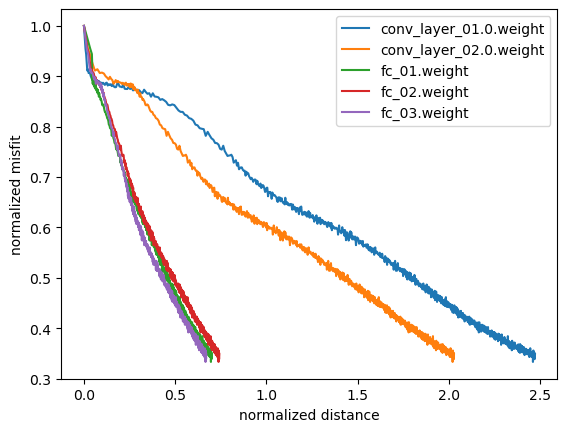

In [5]:
# calculating the average results
mean_result_tensor_500 = result_tensor_500.mean(dim=2)

legend_name_arr = list(filter(lambda x: x.find('weight') != -1, [name for name, _ in LeNet(10).named_parameters()]))

# create the mean dict
mean_misfit_distance_dict_500 = []
for idx, row in enumerate(mean_result_tensor_500):
    mean_misfit_distance_dict_500.append({})
    mean_misfit_distance_dict_500[idx]['misfit'] = row[0].item()
    for name_idx, name in enumerate(legend_name_arr):
        mean_misfit_distance_dict_500[idx][name] = row[name_idx + 1].item()

with open('./misfit_distance_500_json/mean_misfit_distance_500.json', 'w') as fp:
        json.dump(mean_misfit_distance_dict_500, fp, indent=6)

plt.figure()
for idx, name in enumerate(legend_name_arr):
    plt.plot(mean_result_tensor_500[:, idx + 1], mean_result_tensor_500[:, 0], label=name)
plt.xlabel('normalized distance')
plt.ylabel('normalized misfit')
plt.legend()
plt.show()

In [ ]:
result_tensor_5000 = torch.zeros((num_of_iterations, len(list(LeNet(num_classes).parameters())) + 1, num_of_training_round))
for training_round in range(num_of_training_round):
    # dataset with 5000 samples
    dataset_5000_indices = np.random.choice(gen_idx_arr, 5000, replace=False)
    mnist_dataset_5000 = Subset(mnist_dataset, dataset_5000_indices)

    mnist_dataloader_5000 = DataLoader(mnist_dataset_5000, batch_size=batch_size, shuffle=True)
    mnist_dataloader_5000_mean_std = DataLoader(mnist_dataset_5000, batch_size=len(mnist_dataset_5000))
    # find the normalization parameters (mean and std) for a channel
    mean = None
    std = None
    for (data, _) in mnist_dataloader_5000_mean_std:
        data, _ = data.to(device), _.to(device)
        mean = data.mean()
        std = data.std()

    # model
    model = LeNet(num_classes).to(device)

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # save init model and weight parameters
    init_model = copy.deepcopy(model).to(device)

    # training
    num_of_epoch = int(num_of_iterations / (len(mnist_dataset_5000) / batch_size))

    misfit_distance_dict = []
    idx = 0
    loss = None
    for epoch in range(num_of_epoch):
        for (data, label) in mnist_dataloader_5000:
            data, label = data.to(device), label.to(device)
            data = (data - mean) / std

            misfit_distance_dict.append({})

            misfit_distance_dict[idx]['misfit'] = normalized_misfit(label, data, init_model, model)
            result_tensor_5000[idx, 0, training_round] = misfit_distance_dict[idx]['misfit']

            misfit_distance_dict[idx]['distance'] = normalized_distance(init_model, model)
            for val_idx, value in enumerate(misfit_distance_dict[idx]['distance'].values()):
                result_tensor_5000[idx, val_idx + 1, training_round] = value
            optimizer.zero_grad()

            predictions = model(data)
            loss = criterion(predictions, label)
            loss.backward()
            optimizer.step()
            idx = idx + 1

        if (epoch + 1) % 5 == 0:
            print('training round: {}, epoch: {}/{}, loss: {}'.format(training_round + 1, epoch + 1, num_of_epoch, loss))

    with open('./misfit_distance_5000_json/misfit_distance_{}.json'.format(training_round + 1), 'w') as fp:
        json.dump(misfit_distance_dict, fp, indent=6)

    print('training round: {} is done'.format(training_round + 1))

In [ ]:
# calculating the average results
mean_result_tensor_5000 = result_tensor_5000.mean(dim=2)

legend_name_arr = list(filter(lambda x: x.find('weight') != -1, [name for name, _ in LeNet(10).named_parameters()]))

# create the mean dict
mean_misfit_distance_dict_5000 = []
for idx, row in enumerate(mean_result_tensor_5000):
    mean_misfit_distance_dict_5000.append({})
    mean_misfit_distance_dict_5000[idx]['misfit'] = row[0].item()
    for name_idx, name in enumerate(legend_name_arr):
        mean_misfit_distance_dict_5000[idx][name] = row[name_idx + 1].item()

with open('./misfit_distance_5000_json/mean_misfit_distance_5000.json', 'w') as fp:
        json.dump(mean_misfit_distance_dict_5000, fp, indent=6)


plt.figure()
for idx, name in enumerate(legend_name_arr):
    plt.plot(mean_result_tensor_5000[:, idx + 1], mean_result_tensor_5000[:, 0], label=name)
plt.legend()
plt.show()